# Breast Cancer Segmentation Tcia

We will designing and developing MSGRAP DL model based on H. Lee's research paper. We will adapt it for be trained on breast cancer dataset (CT, MRI, PET) since H. Lee originally trained it on breast cancer ultrasound images. We will note down the differences as we work out the implementation.

Instead of using BREAST DIAGNOSIS dataset, we will use `UCSF's Breast Cancer MRI NACT Pilot` dataset since it also has segmentation masks

Duke Breast Cancer Dataset

[1] H. Lee, J. Park and J. Y. Hwang, "Channel Attention Module With Multiscale Grid Average Pooling for Breast Cancer Segmentation in an Ultrasound Image," in IEEE Transactions on Ultrasonics, Ferroelectrics, and Frequency Control, vol. 67, no. 7, pp. 1344-1353, July 2020, doi: [10.1109/TUFFC.2020.2972573](https://ieeexplore-ieee-org.libaccess.sjlibrary.org/document/8988165)

Referenced 2D Channel - Spatial Attention (Squeeze & Excite) VGG based TensorFlow Keras code in tutorial [Attending to Channels Using Keras and TensorFlow](https://pyimagesearch.com/2022/05/30/attending-to-channels-using-keras-and-tensorflow/)

"Train a Neural Network to Detect Breast MRI Tumors with PyTorch: Part 1 (Assembling Data)": https://sites.duke.edu/mazurowski/2022/07/13/breast-mri-cancer-detect-tutorial-part1/

## Outline

- Prepare Tcia Breast Diagnosis Data
- Breast Segmentation Model Architecture
- Train Breast Segmentation ML/DL Models
- Evaluate Breast Segmentation ML/DL Models Quantitatively
- Evaluate Breast Segmentation ML/DL Models Qualitatively
- Deploy Breast Segmentation DL Model for Inference

In [1]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Prepare Duke's Breast Cancer MRI Seg Data

In [2]:
import pandas as pd
import numpy as np
import os
import pydicom as dicom
from tqdm import tqdm
from skimage.io import imsave
import matplotlib.pylab as plt

In [3]:
# /media/james/My Passport/Jetson_TX2_CMPE258/
# duke-breast-cancer-mri/Duke-Breast-Cancer-MRI_v2_20220609/
# manifest-1654812109500
duke_bc_base_dir = os.path.join("/media","james", "My Passport",
    "Jetson_TX2_CMPE258", "duke-breast-cancer-mri")

duke_bc_data_dir = duke_bc_base_dir + \
    os.path.join("/Duke-Breast-Cancer-MRI_v2_20220609", 
                 "manifest-1654812109500")

In [4]:
print(duke_bc_data_dir)

/media/james/My Passport/Jetson_TX2_CMPE258/duke-breast-cancer-mri/Duke-Breast-Cancer-MRI_v2_20220609/manifest-1654812109500


In [5]:
breast_mri_duke_clinical = pd.read_csv(duke_bc_data_dir + "/metadata.csv")
breast_mri_duke_clinical.head(10)

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.1754149663016455182384...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_001,1.3.6.1.4.1.14519.5.2.1.1860515210678639712695...,MRI BREAST BILATERAL WWO,01-01-1990,ax t1 tse c,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,42,5.60 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_001/01-01-...,2022-11-20T08:47:56.032
1,1.3.6.1.4.1.14519.5.2.1.1857778498036652445367...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_001,1.3.6.1.4.1.14519.5.2.1.1860515210678639712695...,MRI BREAST BILATERAL WWO,01-01-1990,ax dyn pre,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,160,64.60 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_001/01-01-...,2022-11-20T08:48:51.95
2,1.3.6.1.4.1.14519.5.2.1.1072629657499780353316...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_001,1.3.6.1.4.1.14519.5.2.1.1860515210678639712695...,MRI BREAST BILATERAL WWO,01-01-1990,ax dyn 3rd pass,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,160,64.61 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_001/01-01-...,2022-11-20T08:48:54.638
3,1.3.6.1.4.1.14519.5.2.1.1514720349923003958578...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_001,1.3.6.1.4.1.14519.5.2.1.1860515210678639712695...,MRI BREAST BILATERAL WWO,01-01-1990,ax dyn 1st pass,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,160,64.61 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_001/01-01-...,2022-11-20T08:48:56.832
4,1.3.6.1.4.1.14519.5.2.1.1602809643137194123479...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_002,1.3.6.1.4.1.14519.5.2.1.2934485107964891261049...,MRI BREAST BILATERAL W WO,01-01-1990,ax t1,GE MEDICAL SYSTEMS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,60,31.59 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-...,2022-11-20T08:49:37.536
5,1.3.6.1.4.1.14519.5.2.1.1702386334115195086234...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_002,1.3.6.1.4.1.14519.5.2.1.2934485107964891261049...,MRI BREAST BILATERAL W WO,01-01-1990,Ph1ax 3d dyn,GE MEDICAL SYSTEMS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,142,74.77 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-...,2022-11-20T08:50:16.244
6,1.3.6.1.4.1.14519.5.2.1.2992581698000354937472...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_001,1.3.6.1.4.1.14519.5.2.1.1860515210678639712695...,MRI BREAST BILATERAL WWO,01-01-1990,ax dyn 4th pass,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,160,64.61 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_001/01-01-...,2022-11-20T08:50:17.166
7,1.3.6.1.4.1.14519.5.2.1.2505476786936590735231...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_002,1.3.6.1.4.1.14519.5.2.1.2934485107964891261049...,MRI BREAST BILATERAL W WO,01-01-1990,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,204.91 KB,./Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-...,2022-11-20T08:50:18.055
8,1.3.6.1.4.1.14519.5.2.1.3613244600992118800704...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_001,1.3.6.1.4.1.14519.5.2.1.1860515210678639712695...,MRI BREAST BILATERAL WWO,01-01-1990,ax dyn 2nd pass,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,160,64.61 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_001/01-01-...,2022-11-20T08:50:20.579
9,1.3.6.1.4.1.14519.5.2.1.2920879504444133146439...,Duke-Breast-Cancer-MRI,NO,https://doi.org/10.7937/TCIA.e3svre93,Breast_MRI_002,1.3.6.1.4.1.14519.5.2.1.2934485107964891261049...,MRI BREAST BILATERAL W WO,01-01-1990,ax 3d dyn,GE MEDICAL SYSTEMS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,142,74.77 MB,./Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-...,2022-11-20T08:50:54.088


In [6]:
boxes_path = "Annotation_Boxes.xlsx"

In [7]:
seg_file_mapping = "segmentation_filepath_mapping.csv"

In [8]:
path_file_mapping = "Breast-Cancer-MRI-filepath_filename-mapping.xlsx"
target_png_dir = "png_out"
if not os.path.exists(target_png_dir):
    os.makedirs(target_png_dir)

### Load Breast Cancer Segmentation Filepath Mapping CSV

In [9]:
bc_seg_file_mapping_df = pd.read_csv(duke_bc_base_dir + os.sep + seg_file_mapping)
bc_seg_file_mapping_df.head()

,Patient ID,Segmentation Label,Slice File,Full Descriptive Path
0,Breast_MRI_002,Fatty tissue of breast,1-125.dcm,Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-19...
1,Breast_MRI_002,Fatty tissue of breast,1-030.dcm,Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-19...
2,Breast_MRI_002,Fatty tissue of breast,1-073.dcm,Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-19...
3,Breast_MRI_002,Mammary Fibroglandular Tissue,1-116.dcm,Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-19...
4,Breast_MRI_002,Mammary Fibroglandular Tissue,1-073.dcm,Duke-Breast-Cancer-MRI/Breast_MRI_002/01-01-19...


### Load Breast Cancer BBox Filepath Excel

In [10]:
bc_bbox_df = pd.read_excel(duke_bc_base_dir + os.sep + boxes_path, index_col=None, names=None)
bc_bbox_df.head()

,Patient ID,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
0,Breast_MRI_001,234,271,308,341,89,112
1,Breast_MRI_002,251,294,108,136,59,72
2,Breast_MRI_003,351,412,82,139,96,108
3,Breast_MRI_004,262,280,193,204,86,95
4,Breast_MRI_005,188,213,138,178,76,122


### Load Breast Cancer MRI Filepath Filename Mapping Excel

Load only Fat-Saturated MR exams and only include patients
patients 1 - 100.

In [11]:
bc_mri_path_file_mapping_df = pd.read_excel(duke_bc_base_dir + os.sep + path_file_mapping, index_col=None, header=None)
drop_nan_cols_list = bc_mri_path_file_mapping_df.columns[4:].values.tolist()
bc_mri_path_file_mapping_df = bc_mri_path_file_mapping_df.drop(drop_nan_cols_list, axis=1)
bc_mri_path_file_mapping_header = bc_mri_path_file_mapping_df.loc[0,:].values.tolist()
bc_mri_path_file_mapping_df = bc_mri_path_file_mapping_df[1:]
bc_mri_path_file_mapping_df.columns = bc_mri_path_file_mapping_header

In [12]:
bc_mri_path_file_mapping_df.head()

,sop_instance_UID,original_path_and_filename,classic_path,descriptive_path
1,1.3.6.1.4.1.14519.5.2.1.1805789812895034139917...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...
2,1.3.6.1.4.1.14519.5.2.1.4903237729147735321973...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...
3,1.3.6.1.4.1.14519.5.2.1.3061160038794820079325...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...
4,1.3.6.1.4.1.14519.5.2.1.1574717199045785031549...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...
5,1.3.6.1.4.1.14519.5.2.1.2594404476894572978078...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...


In [15]:
bc_mri_path_file_mapping_df.loc[1, "original_path_and_filename"]

'DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_001_post_1_001.dcm'

In [17]:
bc_mri_path_file_mapping_df.loc[1, "original_path_and_filename"].split("/")[1]

'Breast_MRI_001'

In [18]:
bc_mri_path_file_mapping_df.loc[1, "original_path_and_filename"].split("/")[1].split("_")[-1]

'001'

- Note: each row in **bc_pre_mapping_df** refers to a different 2D slice of a full 3D MRI volume

In [19]:
bc_pre_mapping_df = bc_mri_path_file_mapping_df[bc_mri_path_file_mapping_df["original_path_and_filename"].str.contains("pre")]

In [20]:
bc_pre_mapping_df.head()

,sop_instance_UID,original_path_and_filename,classic_path,descriptive_path
641,1.3.6.1.4.1.14519.5.2.1.1622543824533841316221...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...
642,1.3.6.1.4.1.14519.5.2.1.2095737470789034615864...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...
643,1.3.6.1.4.1.14519.5.2.1.7648352393594634493272...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...
644,1.3.6.1.4.1.14519.5.2.1.2333724865431423854264...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...
645,1.3.6.1.4.1.14519.5.2.1.3037519639975787441522...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...


In [21]:
crossref_pattern = "|".join(["DICOM_Images/Breast_MRI_{:03d}".format(s)
    for s in list(range(1, 101))])
bc_pre_mapping_df = bc_pre_mapping_df[bc_pre_mapping_df["original_path_and_filename"].str.contains(crossref_pattern)]

- Next we are going to write code to extract .png files from raw DICOM data as .png files work nicely with PyTorch & TensorFlow. The labels we will assign to each extracted png are related to this classification task.

### Defining Classification Task

- Train a classification model to detect the presence of cancer within breast MRI slices. We take all 2D slices that contain a tumor bounding box or segmentation mask to be positive (labeled with '1') and all other slices at least five slices away from the positive slices to be negative ('0').

- We write a helper function for saving a single 2D slice .png image of a 3D MRI (each DICOM file contains a single slice). We will name function `save_dcm_slice()` taking 3 arguments: `dcm_fname, label, vol_idx`

- dcm_fname: filename of source DICOM
- label: cancer label of that slice, 0 for negative or 1 for positive
- vol_idx: patient number/index of the MRI out of entire dataset

### Save Each DCM 2D MRI Slice as PNG Per 3D MRI

In [22]:
def save_dcm_slice(dcm_fname, label, vol_idx):
    # create a path to save the slice .png file in, according to the original
    # DICOM filename and target label
    png_path = dcm_fname.split("/")[-1].replace(".dcm",    "-{}.png".format(vol_idx))
    label_dir = "pos" if label == 1 else "neg"
    png_path = os.path.join(target_png, label_dir, png_path)
    
    if not os.path.exists(os.path.join(target_png_dir, label_dir)):
        os.makedirs(os.path.join(target_png_dir, label_dir))
        
    if not os.path.exists(png_path):
        # only make the png image if it doesn't already exist
        # (if you're running this after the first time)
        
        # load DICOM file with pydicom library
        try:
            dcm = pydicom.dcmread(dcm_fname)
        except FileNotFoundError:
            # fix possible errors in filename from list
            dcm_fname_split = dcm_fname.split("/")
            dcm_fname_end = dcm_fname.split[-1]
            assert dcm_fname_end.split("-")[1][0] == "0"
            
            dcm_fname_end_split = dcm_fname_end.split("-")
            dcm_fname_end = "-".join([dcm_fname_end_split[0], dcm_fname_end_split[1][1:]])
            
            dcm_fname_split[-1] = dcm_fname_end
            dcm_fname = "/".join(dcm_fname_split)
            dcm = pydicom.dcmread(dcm_fname)
        
        # convert DICOM into numerical numpy array of pixel intensity values
        img = dcm.pixel_array
        
        # convert uint16 datatype to float, scaled properly for uint8
        img = img.astype(np.float) * 255. / img.max()
        # convert from float -> uint8
        img = img.astype(np.uint8)
        # invert image if necessary, according to DICOM metadata
        img_type = dcm.PhotometricInterpretation
        if img_type == "MONOCHOME1":
            img = np.invert(img)
            
        # save final .png
        imsave(png_path, img)

### Iterate Each 3D MRI Associated with Single Breast Tumor Seg

As each patient 3D MRI volume is associating with a single breast tumor segmentation mask, so are all the 2D slices (DICOMS) within that volume. 

We will train a network on a balanced amount of positive and negative class samples, so it doesnt focus too much on one of the two classes. We will extract 2600 positive images and 13500 negative images to maintain a class balance.

The following code iterates through `bc_pre_mapping_df`

In [ ]:
# number of examples for each class
N_class = 2600
# counts of examples extracted from each class
ct_negative = 0
ct_positive = 0

# initialize iteration index of each patient volume
vol_idx = -1
for row_idx, row in tqdm(bc_pre_mapping_df.iterrows(), total=N_class*2):
    # indices start at 1 here
    new_vol_idx = int((row["original_path_and_filename"].split("/")[1]).split("_")[-1])
    slice_idx = int(((row["original_path_filename"].split("/")[-1]).split("_")[-1]).replace(".dcm", ""))
    
    # new volume: get tumor bounding box

### Extrct Img Files from Raw MRI DICOM data

In [ ]:
# loop through "Subject ID"s
    # for each "Subject ID", check their "Series Description",
        # if it equals "PE Segmentation thresh*",
            # get "File Location", append that path
        # if it equals "Breast Tissue Segmentation",
            # get "File Location", append that path

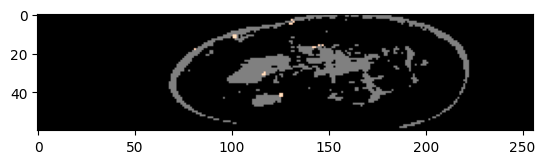

In [32]:
# UCSF-BR-01
# image_path = "/home/james/Downloads/Jetson_TX2_CMPE258/"
# "Breast_Cancer_MR_PT_CT_MG_Clinical_Img_Analyses_100Percent/"
# "manifest-BbshIhaG7188578559074019493/BREAST-DIAGNOSIS/BreastDx-01-0001/"
# "08-12-2008-NA-MRI Breast Bilateral with and without Contrast-44317/"
# "401.000000-T2WTSE SENSE-75663/1-40.dcm"

# pe_seg_mri_path = ucsf_bc_data_dir + "/Breast-MRI-NACT-Pilot/" + "UCSF-BR-01/" + \
#     "03-29-1990-218019-MR BREAST-74237/" + \
#     "42000.000000-PE Segmentation thresh70-70064/" + \
#     "1-1.dcm"

pe_seg_mri_path = "/media/james/My Passport/Jetson_TX2_CMPE258/breast-mri-nact-pilot-ucsf/imgs_and_seg_dicom/manifest-RbPGRCVv7392292744865323559/Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-218019-MR BREAST-74237/42000.000000-PE Segmentation thresh70-70064/1-1.dcm"
pe_seg_mri_ds = dicom.dcmread(pe_seg_mri_path)

breast_tissue_seg_path = "/media/james/My Passport/Jetson_TX2_CMPE258/breast-mri-nact-pilot-ucsf/imgs_and_seg_dicom/manifest-RbPGRCVv7392292744865323559/Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-218019-MR BREAST-74237/42001.000000-Breast Tissue Segmentation-38497/1-1.dcm"
breast_tissue_seg_ds = dicom.dcmread(breast_tissue_seg_path)

slice2show = 90

plt.imshow(breast_tissue_seg_ds.pixel_array[:,:,slice2show], cmap=plt.cm.gray)
plt.imshow(pe_seg_mri_ds.pixel_array[:,:,slice2show], alpha=0.5, cmap=plt.cm.copper)

## Breast Segmentation Model Architecture

DL MSGRAP Breast Cancer Segmentation Architecture:

- Encoder
    - Based on VGGNet except for batch normalization and channel attention modules
    - Use all conv layers with C' filters with size 3x3xC
    - Upsample the feature maps using a 4x4 transpose conv with a stride of 2
    - Unlike UNet, only 2 feature maps from encoder are connected to decoder
- Decoder
    - symmetrical encoder architecture built into decoder
    - Use all conv layers with C' filters with size 3x3xC
    - Final conv layer has 2 filters with size 3x3x64
    - Obtain final segmentation results into binary classes via argmax with threshold 0.5

The network receives a breast ultrasound image as input and predicts its semantic segmentation result.

- Note: C and C' are the previous and current number of feature maps, except for the final conv layer

- Note: batch normalization is highly influenced by a batch size: the smaller the batch size, the lower the performance is. Small batch size reduces the generalization ability. H. Lee et al uses group batch normalization since it has little effect on batch size and the dataset used in experiments had enough spatial size

- Note: group normalization divides each channel into N groups and normalizes the features within each group regardless of the batch size. Thus, it doesnt depend on the batch size and can overcome the generalization issues caused by the small batch size when the network is trained with large input imagess.

- Note: After performing additional experiment, H. Lee et al demonstrated that their  network architecture with 2 feature maps connected between the encoder and decoder performed better than UNet like architectures.
    - It is better to not use low-level features in the network since most ultrasound images are noisy. (similar for PET, SPECT).
    
- Note: H. Lee et al also conducts the ablation study for architecture with two of the tenfold datasets.

- Note: Semantic segmentation F1 Score: UNet = 0.78, H. Lee's MSGRAP = 0.79

![msgrap_h_lee_breast_cancer_segmentation](./msgrap_h_lee_breast_cancer_segmentation.jpg)


In [2]:
class model():
    def __init__(self, input_shape, ratio, blocks, num_classes,
        dense_units, conv_filters, is_squeeze_excite, optimizer,
        loss, metrics):
        self.input_shape = input_shape
        self.rate = ratio
        self.block = blocks
        self.num_classes = num_classes
        
        self.dense_units = dense_units
        self.conv_filters = conv_filters
        
        # Flag decides whether to add squeeze excitation layer
        # to network. This is channel - spatial attention layer
        self.is_squeeze_excite = is_squeeze_excite
        
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        pass

    def split(self, resized_img, resized_mask):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            resized_img, resized_mask, test_size=0.1)
    
    def data_gen(self, img_list, mask_list, batch_size):
        pass
    
#     def conv_stem(self, inputs, filters=3, kernel_size=3):
#         # pass the input through a CONV => ReLU layer block
#         x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size, kernel_size),
#             kernel_initializer = "he_normal", padding = "same")(inputs)
#         x = Activation("relu")(x)
#         x = GroupNormalization()(x)
#         if self.is_squeeze_excite:
#             x = self.squeeze_excite_block(x)
#             x = Activation('relu')(x)
#         return x
    
#     def learner(self, x):
#         # build the learner by stacking 3D convolutional layer blocks
#         for num_layers, num_filters in self.blocks:
#             x = self.convolutional_block(x, num_layers, num_filters)
#         return x
    
    def convolutional_block(self, x, filters=3, kernel_size=3, num_blocks=2):
        """conv layer followed by group normalization"""
        """ iterate over the number of layers and build a block
            with 3D convolutional layers"""
        for i in range(num_blocks):
            x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size, kernel_size),
                       kernel_initializer = 'he_normal', padding = 'same')(x)
            x = Activation('relu')(x)
            x = GroupNormalization()(x)
            if self.is_squeeze_excite:
                x = self.squeeze_excite_block(x)
                x = Activation('relu')(x)
        return x
    
    def squeeze_excite_block(self, x):
        # store the input
        shortcut = x
        
        # calculate the number of filters the input has
        filters = x.shape[-1]
        
        # the squeeze operation reduces the input dimensionality
        # here we do a global average pooling across the filters,
        # which reduces the input to a 2D feature map
        x = GlobalAveragePooling3D(keepdims=True)(x)
    
        # reduce the number of filters to C/r
        x = Dense(filters // self.ratio, activation="relu",
            kernel_initializer="he_normal", use_bias=False)(x)
    
        # the excitation operation restores the input dimensionality
        x = Dense(filters, activation="sigmoid",
            kernel_initializer="he_normal", use_bias=False)(x)
        
        # multiply the attention weights with the original input
        x = Multiply()([shortcut, x])
    
        # return the output of the SE block
        return x
    
    def msgrap(input_img, filters=64, dropout=0.2):
        """MSGRAP based on 3D UNet and Squeeze Excitation Network
           Squeeze Excitation is the channel - spatial attention layer(s)
           This implementation is based on the diagram above. It initially
           is initially designed for breast cancer ultrasound, so we will
           see how it does for CT, MRI, PET.
        """
        # 64 filters for first two 3D conv blocks
        conv1 = convolutional_block(input_img, filters*1, kernel_size=3,
                    num_blocks=2)
        
        # MaxPooling3D, then 128 filters for next two 3D conv blocks
        pool2 = MaxPooling3D((2,2,2))(conv1)
        conv2 = convolutional_block(pool2, filters*2, kernel_size=3,
                    num_blocks=2)
        
        # MaxPooling3D, then 256 filters for next three 3D conv blocks
        pool3 = MaxPooling3D((2,2,2))(conv2)
        conv3 = convolutional_block(pool3, filters*4, kernel_size=3,
                    num_blocks=3)
        
        # MaxPooling3D, then 512 filters for next three 3D conv blocks
        pool4 = MaxPooling3D((2,2,2))(conv3)
        conv4 = convolutional_block(pool4, filters*8, kernel_size=3,
                    num_blocks=3)
        
        # MaxPooling3D, then 512 filters for next three 3D conv blocks
        pool5 = MaxPooling3D((2,2,2))(conv4)
        conv5 = convolutional_block(pool5, filters*8, kernel_size=3,
                    num_blocks=3)
        
        # Conv3DTranspose, concatenation w/ conv4, then 512 filters for
        # next three 3D conv blocks
        ups6 = Conv3DTranspose(filters*8, (4,4,4), strides=(2,2,2), padding="same",
                              activation="relu", kernel_initializer="he_normal")(conv5)
        ups6 = concatenate([ups6, conv4])
        conv6 = convolutional_block(ups6, filters*8, kernel_size=3,
                    num_blocks=3)
        
        # Conv3DTranspose, concatenation w/ conv3, then 256 filters for
        # next three 3D conv blocks
        ups7 = Conv3DTranspose(filters*4, (4,4,4), strides=(2,2,2), padding="same",
                              activation="relu", kernel_initializer="he_normal")(conv6)
        ups7 = concatentate([ups7, conv3])
        conv7 = convolutional_block(ups7, filters*4, kernel_size=3,
                    num_blocks=3)
        
        # Conv3DTranpose, then 128 filters for next two 3D conv blocks
        ups8 = Conv3DTranpose(filters*2, (4,4,4), strides=(2,2,2), padding="same",
                             activation="relu", kernel_initializer="he_normal")(conv7)
        conv8 = convolutional_block(ups8, filters*2, kernel_size=3,
                    num_blocks=2)
        
        # Conv3DTranspose, then 64 filters for next two 3D conv blocks
        ups9 = Conv3DTranspose(filters*1, (4,4,4), strides=(2,2,2), padding="same",
                              activation="relu", kernel_initializer="he_normal")(conv8)
        conv9 = convolutional_block(ups9, filters*1, kernel_size=3,
                    num_blocks=2)
        # Final conv layer has 2 filters with size 3x3x64
        # Obtain final segmentation results into binary classes via argmax with threshold 0.5
        outputs = Conv3D(2, (3,3,64), activation="sigmoid", padding="same")(conv9)
        model = Model(inputs=[input_img], outputs=[outputs])
        return model

## Train Breast Segmentation ML/DL Models

To evaluate the performance of their proposed networks (MSGRAP, etc), H. Lee et al trained different models, such as 

- FCN
- UNet
- SegNet
- PSPNet-18

Then compared their performance.

Loss function:

`L_theta_k_D = -(M-1)_sum_(c=0) (GT_c)log(f(I_theta)_c)`

- Note: GT_c is the predicted probability and the binary indicator for the class, c
- Note: breast cancer segmentation is a binary classification for each pixel, use `M = 2`

- Note: since the breast ultrasound cancer datasets were limited, H. Lee et al  configured the training and testing processes as tenfold cross-validation.

- Note: Divided the data into 146 or 147 breast cancer ultrasound images for training
    - 16 or 17 breast cancer ultrasound images for testing in each validation step

- Note: H. Lee et al agumented each patch by random horizontal and vertical flips and random 90 deg rotations

- Note: for training and testing, all image sizes were set to average 454x537 pixels

- Note: for training, the weights of all conv layers were initialized `Kaiming initialization`

Note: Adam optimization method with parameters was used:

- Beta_1 = 0.9
- Beta_2 = 0.999
- epsilon = 10^-8

- Note: `Learning rate = 10^-3` and was `reduced by half` every `30 epochs`

- Note: `mini-batch size = 8`

- Note: models were trained for `120 epochs`

- Note: PyTorch was used to implement and train networks

NOTE: it took four days to train the models using:

- Intel Zeon E5-2620 at 2.0 GHz
- NVIDIA TITAN RTX (24GB)

## Evaluate Breast Segmentation ML/DL Models Quantitatively

### Performance Metrics

For quantitative comparisions of DL MSGRAP with other methods, H. Lee et al used global accuracy, F1 score, sensitivity, specificity.

Accuracy = `(TP+TN)/(TP+FP+FN+TN)`

F1 = `(2*TP)/(2*TP+FP+FN)`

IoU = `TP/(TP+FP+FN)`

- Note: Accuracy is most basic metric for several CV tasks
- Note: F1 score is good for imbalanced data. For ex, in H. Lee et al's dataset, there was a small portion of cancer among all breast ultrasound images, this data set can be considered imbalanced.
- Note: this dataset was imbalanced, it consists of 5% of cancer pixels and 95% of nomal pixels. So, H. Lee et al used FPR, precision, intersection over union (IoU), and area under the curve (AUC) of precision and recall (PR) for fair evaluation.
- Note: AUC metrics used a sweep of the threshold from `p=0` to `p=1` as opposed to `p=0.5` (argmax) used for the remaining non-AUC metrics.
- Note: FPR is number of false positive over the one of the condition negatives.
- Note: IoU metric is commonly used in semantic segmentation

Show metrics in a table for models:

- FCN, UNet, SegNet, PSPNet-18, ENCNet-18
- Ours-GAP, Ours-GRAP, Ours-MSGRAP

H. Lee et al didn't use semantic segmentation networks based on ResNet-34, 51 and DesneNet that have more than 18 conv layers, so there would be fair comparisons since those networks have many more parameters than theirs.

- Ours-MSGRAP had better `F1 score = 0.7658` than other models
    - FCN = 0.7123, UNet = 0.7132, SegNet = 0.7225, PSPNet-18 = 0.7520, ENCNet-18 = 0.7266
    
Ours-MSGRAP showed higher performance than other models in global accuracy, specificity, FPR, precision and IoU